In [1]:
from diffusers import UNet2DModel
from matplotlib import pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import numpy as np

import torchvision
from torchvision import transforms

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#Load the data and choose one class, then create the data loader.
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        #To do
        self.transform = transform
        self.images = images
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #To do
        return self.transform(self.images[idx]) if self.transform is not None else self.images[idx]


preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = DataLoader(CustomDataset(cifar_dataset.data[np.array(cifar_dataset.targets) == 5], transform=preprocess), batch_size=128) # choosing the dog class

In [5]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

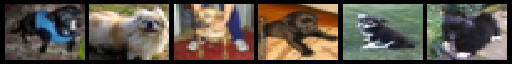

In [6]:
x_test = next(iter(dataloader))[:6]
show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)

### Forward Process

In [7]:
beta_min = 0.0001
beta_max = 0.02

num_timesteps = 1000

beta_samples = torch.linspace(beta_min, beta_max, steps=num_timesteps, device=device)

alphas = torch.cumprod(1 - beta_samples, dim=0)

In [8]:
def forward_pass(images, timesteps):
    images = images.to(device)
    timesteps = timesteps.to(device)
    alpha_timesteps = alphas[timesteps].to(device)
    sqrt_alphas = torch.sqrt(alpha_timesteps) # to scale the image

    sqrt_one_minus_alphas = torch.sqrt(1 - alpha_timesteps) # std of noise

    # sample our noise
    noise = torch.randn_like(images) 

    return noise * sqrt_one_minus_alphas[:, None, None, None] + images * sqrt_alphas[:, None, None, None], noise



In [9]:
x = next(iter(dataloader))

In [10]:
num_steps_to_show = 11
timesteps = torch.linspace(0, num_timesteps - 1, steps=num_steps_to_show).long()

peturbed_images = []
for i in range(6):
    peturbed_images.append(forward_pass(torch.stack([x[i]] * num_steps_to_show), timesteps)[0])

peturbed_images = torch.stack(peturbed_images)

Timestep 0


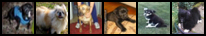

Timestep 99


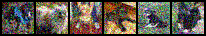

Timestep 199


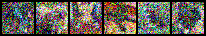

Timestep 299


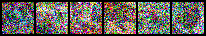

Timestep 399


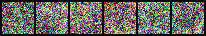

Timestep 499


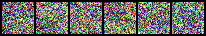

Timestep 599


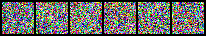

Timestep 699


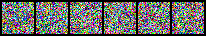

Timestep 799


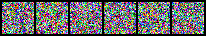

Timestep 899


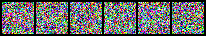

Timestep 999


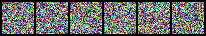

In [11]:
for i in range(num_steps_to_show):
    print(f"Timestep {timesteps[i]}")
    display(show_images(peturbed_images[:, i]))

### Training

In [12]:
model = UNet2DModel(
    sample_size=32,
    block_out_channels=[128, 128, 256, 512]
 ).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 67118851


In [14]:
def train(model,data_loader,criterion,optimizer, epochs):

    for _ in tqdm(range(epochs)):
        for batch_idx, inputs in enumerate(data_loader):
            model.train()
            inputs = inputs.to(device)
            
            # sample some random timesteps
            timesteps = torch.randint(low=0, high=num_timesteps, size=[len(inputs)], device=device)
            peturbed, noise = forward_pass(inputs, timesteps)

            y = model(peturbed, timesteps.float()).sample

            optimizer.zero_grad()
            loss = criterion(y, noise)
            loss.backward()
            optimizer.step()
        
            tqdm.write(f"Batch {batch_idx + 1}, Loss {loss.item()}", end= "\r")


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [16]:
model.train()
epochs = 100
train(model, dataloader, nn.MSELoss(), optimizer, epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

AttributeError: 'generator' object has no attribute 'size'

  0%|          | 0/1000 [00:00<?, ?it/s]

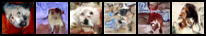

In [ ]:
sample = torch.randn(6, 3, 32, 32).to(device)

#denoise

def get_next(model, x, i):
    beta_i = beta_samples[i]
    alpha_timesteps = alphas[i].to(device)
    
    sqrt_one_minus_alphas = torch.sqrt(1 - alpha_timesteps) # std of noise
    score = -model(x, i).sample.detach() / sqrt_one_minus_alphas[:, None, None, None]


    return (1 / torch.sqrt(1 - beta_i))[:, None, None, None] * (x + beta_i[:, None, None, None] * score) + torch.sqrt(beta_i)[:, None, None, None] * torch.randn_like(x)

model.eval()
with torch.no_grad():
    for i in tqdm(reversed(range(0, num_timesteps)), total=num_timesteps):
        sample = get_next(model, sample, torch.Tensor([i] * sample.shape[0]).long().to(device))

show_images(sample)
